# Final Project Part 2: Stat 102

In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from matplotlib.widgets import Button, CheckButtons
from matplotlib import gridspec
import functools
from Bandit_env import BanditEnv, Interactive_UCB_Algorithm,Interactive_TS_Algorithm

In [233]:
chi = pd.read_csv("chicago.csv")
ny = pd.read_csv("ny.csv")
dc = pd.read_csv("dc.csv")
daily = pd.read_csv("day.csv")

## Question 1: Bandits

### Question 1.1 Formalizing the problem as a Multi-Armed Bandits Problem

In this formalization, the arms would be intersections, the rewards would be the # of individuals who take fliers at that intersection, and the rewards would be bounded, as the max reward we can achieve is the # of fliers we can print out (in the simulation, however, I decide to choose sub-gaussian rewards). The time horizon is the number of intersections we need to visit until we have the optimal intersection. My modeling assumptions are the following:

1. Each day of the week will have the same distribution (i.e. Monday will not have better results than Tuesday)
2. Things like weather do not have an impact on the number of fliers we'll hand out
3. The "popularity" (# of fliers passed at) of one intersection does not have an effect on another intersection

Out of all of these assumptions, I only assume the 3rd the hold, while the first two will likely not hold. Weather definitely has an effect on how many people frequent an intersection, which inturn leads to the # of people who would take a flie. For the first assumption, it is likely to not hold as weekdays will have a larger # of frequenters for an intersection than weekends would. We can test this by joining the dataset with weather conditions, and we can test the day of the week assumption by using the data we currently have.

For regret, we think about it as the average reward achieved from the optimal path minus the average reward from path we took (path being the intersections we visit before finding the optimal intersection).

### Question 1.2 Simulate UCB strategy using past data

In [234]:
def add_from_and_to(x):
    if np.isnan(x['from_count']):
        return x['to_count']
    elif np.isnan(x['to_count']):
        return x['from_count']
    else:
        return x['from_count'] + x['to_count']

In [235]:
chi['starttime'] = pd.to_datetime(chi['starttime'])
chi['Date'] = chi['starttime'].dt.date
chi_rides_from = chi.groupby(['Date', 'from_station_name']).count()[['trip_id']].reset_index()
chi_rides_from.columns = ['Date', 'station_name', 'from_count']
chi_rides_to = chi.groupby(['Date', 'to_station_name']).count()[['trip_id']].reset_index()
chi_rides_to.columns = ['Date', 'station_name', 'to_count']
chi_rides = pd.merge(chi_rides_from, chi_rides_to, how='outer', on=['Date', 'station_name'])
chi_rides['total'] = chi_rides.apply(add_from_and_to, axis=1)
chi_rides = chi_rides[['Date', 'station_name', 'total']].sort_values('total', ascending=False)

In [236]:
dc['Start date'] = pd.to_datetime(dc['Start date'])
dc['Date'] = dc['Start date'].dt.date
dc_rides_from = dc.groupby(['Date', 'Start station']).count()[['Start station number']].reset_index()
dc_rides_from.columns = ['Date', 'station_name', 'from_count']
dc_rides_to = dc.groupby(['Date', 'End station']).count()[['Start station number']].reset_index()
dc_rides_to.columns = ['Date', 'station_name', 'to_count']
dc_rides = pd.merge(dc_rides_from, dc_rides_to, how='outer', on=['Date', 'station_name'])
dc_rides['total'] = dc_rides.apply(add_from_and_to, axis=1)
dc_rides = dc_rides[['Date', 'station_name', 'total']].sort_values('total', ascending=False)

In [237]:
ny['starttime'] = pd.to_datetime(ny['starttime'])
ny['Date'] = ny['starttime'].dt.date
ny_rides_from = ny.groupby(['Date', 'start station name']).count()[['bikeid']].reset_index()
ny_rides_from.columns = ['Date', 'station_name', 'from_count']
ny_rides_to = ny.groupby(['Date', 'end station name']).count()[['bikeid']].reset_index()
ny_rides_to.columns = ['Date', 'station_name', 'to_count']
ny_rides = pd.merge(ny_rides_from, ny_rides_to, how='outer', on=['Date', 'station_name'])
ny_rides['total'] = ny_rides.apply(add_from_and_to, axis=1)
ny_rides = ny_rides[['Date', 'station_name', 'total']].sort_values('total', ascending=False)

In [238]:
chi_10 = chi_rides['station_name'].unique()[0:10]
dc_10 = dc_rides['station_name'].unique()[0:10]
ny_10 = ny_rides['station_name'].unique()[0:10]

In [239]:
chi_rides_10 = chi_rides[chi_rides['station_name'].isin(chi_10)]
dc_rides_10 = dc_rides[dc_rides['station_name'].isin(dc_10)]
ny_rides_10 = ny_rides[ny_rides['station_name'].isin(ny_10)]

### Question 1.2.1 Implementation and Results

For my simluation procedure, I am using the UCB algorithm to achieve a logarithmic (or close to logarithmic) regret for choosing intersections. Regret, in this case, is the average reward achieved from the optimal path minus the average reward from path we took (path being the intersections we visit before finding the optimal intersection). In this process, we will assume the rewards are sub-gaussian, as you have an unlimited amount of fliers you can pass out. We are instantiating our parameters with the observed means from the data, and a general variance across the top 10 intersections. At each step, we look at our past rewards for each arm and take the mean of the rewards and store it, and from those means, we use them to calculate our confidence bounds with the following function if $T != 0$: $\mu_a + \sqrt\frac{2\sigma}{T_a\log(t)}$. We choose the widths of the upper confidence bounds by the constant that is multiplied by our variance ($\sigma$).

### Simulation

In [279]:
def UCB_pull_arm(t,variance,times_pulled,rewards):
    """ 
    Implement the choice of arm for the UCB algorithm
    
    Inputs:
    iteration          - iteration of the bandit algorithm
    times_pulled       - a list of length K (where K is the number of arms) of the number of 
                         times each arm has been pulled
    rewards            - a list of K lists. Each of the K lists holds the samples received from pulling each arm up 
                         to iteration t. 
    
    Returns:
    arm                -  integer representing the arm that the UCB algorithm would choose.
    confidence bounds  -  a list of the upper confidence bounds for each arm
    """

    K=len(times_pulled)
    delta=1.0/t**2
    
    confidence_bounds=[]
    means=[]
    for arm in np.arange(K):
        mu_a = np.mean(rewards[arm])
        T_a = times_pulled[arm]
        if T_a == 0:
            cb = np.inf
        else:
            cb = mu_a + np.sqrt((2*variance)/T_a*np.log(t))
        confidence_bounds.append(cb)
        means.append(mu_a)
    arm=np.argmax(confidence_bounds)
    
    return arm, confidence_bounds, means

### Regret over Time

/Users/tannerarrizabalaga/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tannerarrizabalaga/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tannerarrizabalaga/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


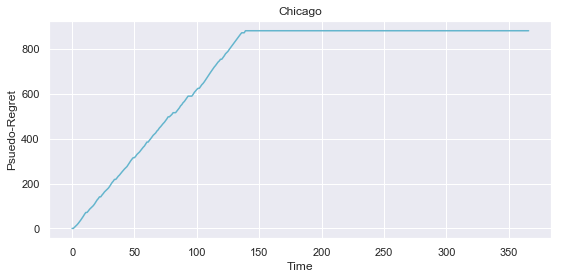

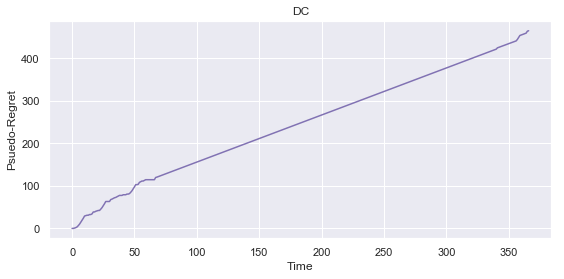

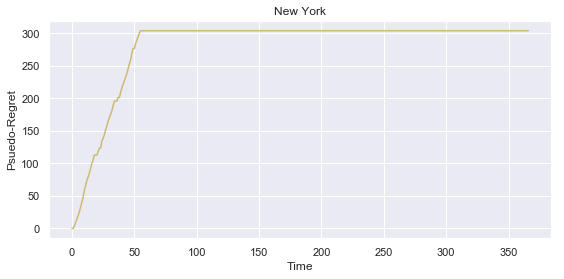

In [280]:
city_names = ['Chicago', 'DC', 'New York']
colors = ['c', 'm', 'y']

index = 0

times_pulled = [[], [], []]
arm_means = [[], [], []]
c_bounds = [[], [], []]

for df in [chi_rides_10, dc_rides_10, ny_rides_10]:
    
    grouped = df.groupby('station_name').mean().sort_values('total', ascending=False)['total']
    means=grouped.values
    variance=np.var(df['total'])
    standard_deviations=[np.sqrt(variance) for arm in range(len(means))]
    arm_to_station = {index: grouped.index.tolist()[index] for index in np.arange(len(grouped))}
    bandit_env=BanditEnv(means,standard_deviations,df,arm_to_station)

    #Initialize Figure
    T=366
    num_runs=20

    plt.rcParams['figure.figsize']=[9,4]
    plt.figure()

    #Initialize pseudo-regret
    UCB_pseudo_regret=0
    for runs in range(num_runs):
        #Initialize Bandit_environment
        bandit_env.initialize(make_plot=0)
        for t in range(1,T+1):
            #Choose arm using UCB algorithm
            arm,confidence_bounds,means=UCB_pull_arm(t,variance,bandit_env.times_pulled,bandit_env.rewards)

            #Pull Arm
            bandit_env.pull_arm(arm, t)
            if runs == 0:
                times_pulled[index].append(bandit_env.times_pulled.copy())
                arm_means[index].append(means.copy())
                c_bounds[index].append(confidence_bounds.copy())
                

        #Keep track of pseudo-regret  
        UCB_pseudo_regret+=np.array(bandit_env.regret)

    #Make plot
    ax = plt.plot(UCB_pseudo_regret/num_runs, color=colors[index])
    ax = plt.xlabel('Time')
    ax = plt.ylabel('Psuedo-Regret')
    ax = plt.title(city_names[index])
    
    index += 1

plt.show()

### Times Pulled by Arm

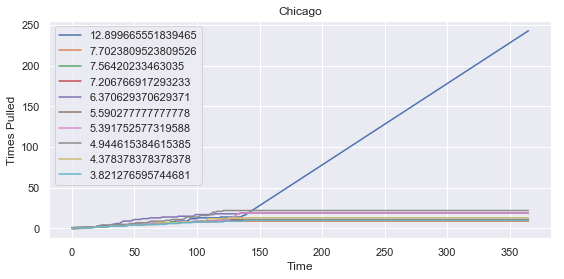

In [308]:
plt.plot(times_pulled[0])
plt.xlabel('Time')
plt.ylabel('Times Pulled')
plt.title('Chicago')
plt.legend(chi_rides_10.groupby('station_name').mean().sort_values('total', ascending=False)['total'].values)

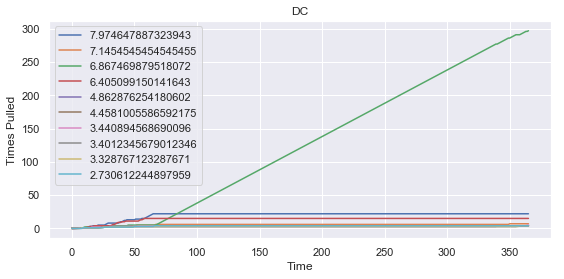

In [309]:
plt.plot(times_pulled[1])
plt.xlabel('Time')
plt.ylabel('Times Pulled')
plt.title('DC')
plt.legend(dc_rides_10.groupby('station_name').mean().sort_values('total', ascending=False)['total'].values)

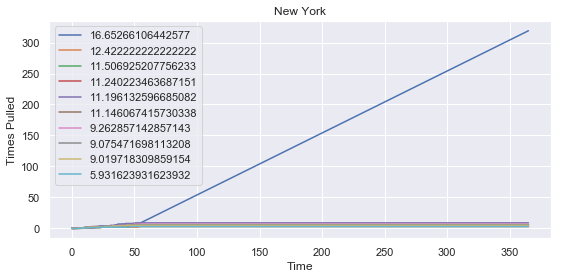

In [310]:
plt.plot(times_pulled[2])
plt.xlabel('Time')
plt.ylabel('Times Pulled')
plt.title('New York')
plt.legend(ny_rides_10.groupby('station_name').mean().sort_values('total', ascending=False)['total'].values)

### Estimated Means over Time

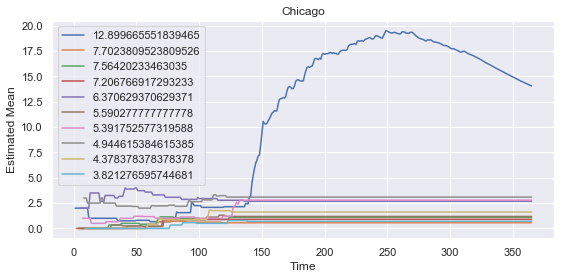

In [311]:
plt.plot(arm_means[0])
plt.xlabel('Time')
plt.ylabel('Estimated Mean')
plt.title('Chicago')
plt.legend(chi_rides_10.groupby('station_name').mean().sort_values('total', ascending=False)['total'].values)

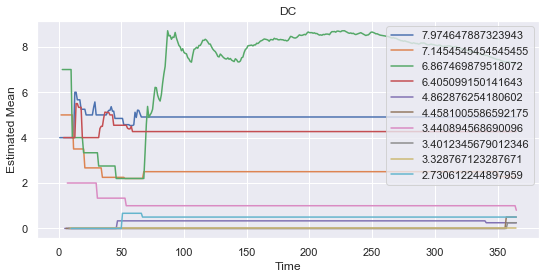

In [312]:
plt.plot(arm_means[1])
plt.xlabel('Time')
plt.ylabel('Estimated Mean')
plt.title('DC')
plt.legend(dc_rides_10.groupby('station_name').mean().sort_values('total', ascending=False)['total'].values)

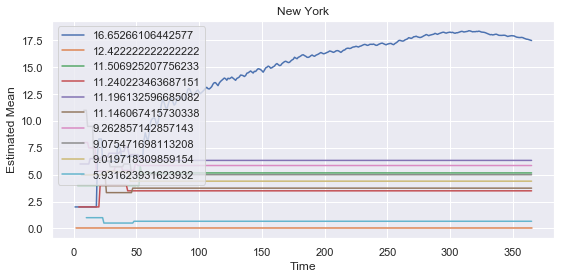

In [313]:
plt.plot(arm_means[2])
plt.xlabel('Time')
plt.ylabel('Estimated Mean')
plt.title('New York')
plt.legend(ny_rides_10.groupby('station_name').mean().sort_values('total', ascending=False)['total'].values)

### Estimated UCB over Time

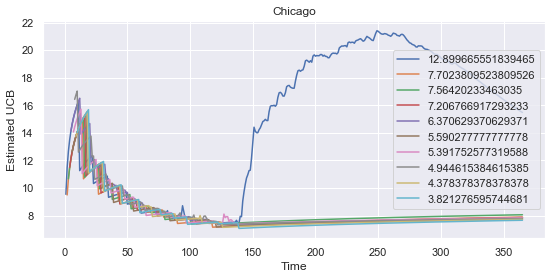

In [314]:
plt.plot(c_bounds[0])
plt.xlabel('Time')
plt.ylabel('Estimated UCB')
plt.title('Chicago')
plt.legend(chi_rides_10.groupby('station_name').mean().sort_values('total', ascending=False)['total'].values)

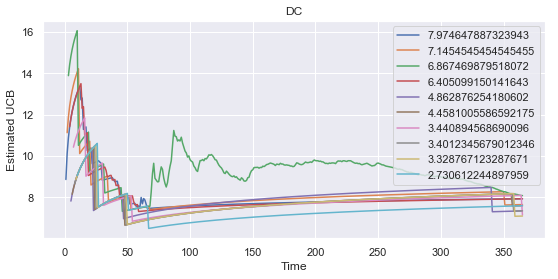

In [315]:
plt.plot(c_bounds[1])
plt.xlabel('Time')
plt.ylabel('Estimated UCB')
plt.title('DC')
plt.legend(dc_rides_10.groupby('station_name').mean().sort_values('total', ascending=False)['total'].values)

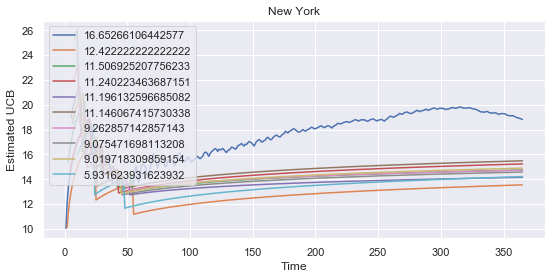

In [316]:
plt.plot(c_bounds[2])
plt.xlabel('Time')
plt.ylabel('Estimated UCB')
plt.title('New York')
plt.legend(ny_rides_10.groupby('station_name').mean().sort_values('total', ascending=False)['total'].values)

### Question 1.2.2 Discussion

Yes, for some of the different orderings we see that the algorithm decides to go for another arm. This usually only happens when the arm we choose has a similar true mean. For an adaptive strategy, I believe accounting for the day of the week or season could really help us. For instance, if we made two different algorithms split by weekday and weekend, we may get different results, and one intersection that is not the optimal intersection on weekdays may do very well on weekends. This can be further improved by splitting on seasons as well, as all cities experience serious drop offs in visit rates during the Winter.

### Question 1.3

The applicability of my simulation/algorithm to the problem I formalized is solid, but I believe there are *much better* methods to approaching this problem. The UCB algorithm was able to find the optimal intersection across all 3 locations, and I do believe we can invest in a promotional program founded on the results of the simulation. However, the simulation ran on **very naive assumptions that likely do not hold in the real world**. For instance, we never kept track of the type of day (weekday vs. weekend), weather, or season for the location, and we assumed the popularity of one location will not affect the traffic at another station. In additions, we had violations associated with the distributions of each intersection, as UCB assumes the same probability distribution for each intersection no matter the time step we are at, and by the nature of the data, this is false.

Ultimately, I would not recommend using UCB to place the person handing out promotional flyers. I would suggest traditional business development strategies to tackle this problem as this method is too complicated and time consuming to tackle a problem that is already well defined -- using visualizations/pure metrics about intersection and make a decision with more business knowledge as well the route I would choose. If I were to alter the algorithm, I would do the split I discussed in the problem above to account for things like weather and seasonality. I believe a solid way to promote the company as well instead of fliers is to move towards digital marketing and promote on social media, as peer-to-peer marketing is out-of-date.



## Question 2

### Question 2.1 EDA

In [103]:
leaked = pd.read_csv('leaked.csv')
berk = pd.read_csv('berkeley.csv')
leaked.head()

,name,sex,zip,month,year
0,Avery Phillips,M,94709,3,1993
1,Grayson Rodriguez,M,94705,6,1998
2,Ethan Baker,M,94712,1,1998
3,Carter Wright,M,94720,7,1995
4,Elijah Young,M,94706,2,1996


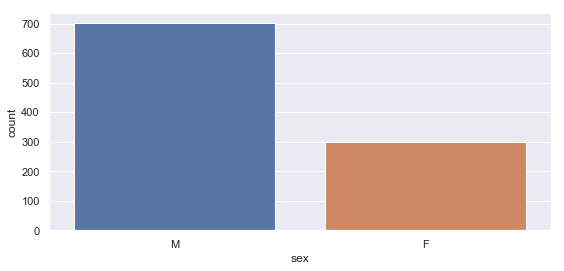

In [104]:
sns.countplot('sex', data=leaked)

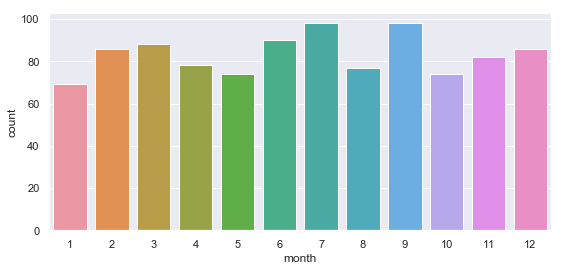

In [105]:
sns.countplot(leaked['month'])

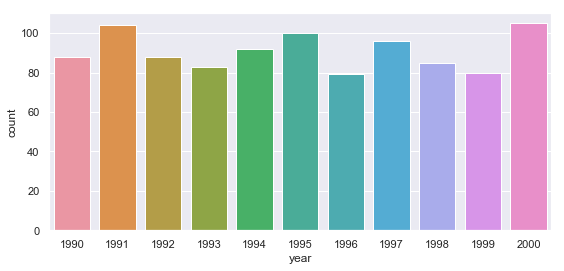

In [106]:
sns.countplot(leaked['year'])

Of the three attributes, two of them are uniformally distributed (month and year) while the last one is not uniformally distributed (sex, there are a lot more males than females). These distributions are the same for the uniformally distributed attributes, but the sex attribute is not the same, as previous datasets had a more even ratio between guys and girls. 

### Question 2.2 Simple Proof of Concept

Create the identifiable dataset. From the code cell below, we see that 43 users (roughly 17%) can be identified in the leaked dataset with only the sex, month, and year columns.

In [209]:
grouped = leaked.groupby(['sex', 'month', 'year']).count()[['name']].reset_index()
grouped = grouped[grouped['name'] == 1]

iden = pd.merge(leaked, grouped[['sex', 'month', 'year']], how='inner', on=['sex', 'month', 'year'])
print(len(iden), 'users can be identified in the leaked dataset with just these 3 attributes')
print(len(iden)/len(leaked.groupby(['sex', 'month', 'year']).count()[['name']].reset_index()))

43 users can be identified in the leaked dataset with just these 3 attributes
0.16862745098039217


In [108]:
iden.head()

,name,sex,zip,month,year
0,Emily Phillips,F,94702,1,1995
1,Evelyn Johnson,F,94701,7,1998
2,Abigail King,F,94703,1,1999
3,Sophia Brown,F,94705,12,1992
4,Olivia White,F,94706,5,2000


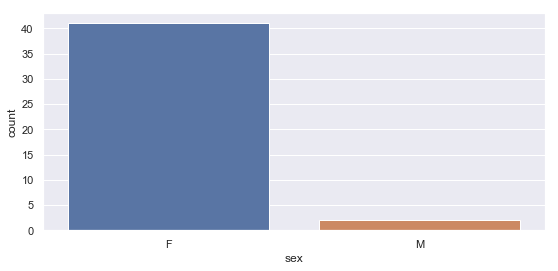

In [109]:
sns.countplot('sex', data=iden)

The distribution above clearly does not match our previous distribution plotted for all of 'leaked'. In 'leaked', we see that there are roughly twice the number of males than females in the dataset, whereas in the identifiable dataset, there are only two men who can be identified by the three attributes.

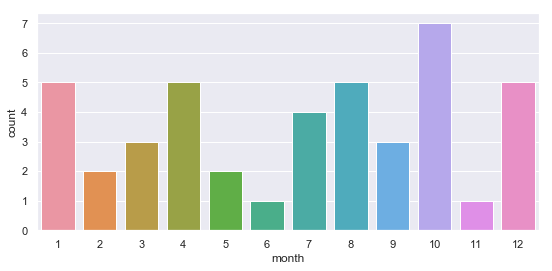

In [110]:
sns.countplot(iden['month'])

In terms of the month, we see that the plot above is roughly similar our original plot which was uniformally distributed, the dips and peaks in the datset can be attributed to the fact that there were only 42 identifiable users.

In [113]:
iden_rides = pd.merge(berk, iden, how='inner', on=['sex', 'month', 'year'])

In [116]:
len(iden_rides)

2205

The script above does an inner join on the identifiable riders and the berkeley dataset, giving us all of their rides in Berkeley.

### Question 2.3 A More Elaborate Attack

In order to obtain $p_1$, $p_2$ in our dataset, we will be running a simple script to that does element-wise comparison between where a user starts/ends and where they live. From the below code snippet, we see that roughly 90% of our users start their rides from their registered zip and roughly 73% of users end their rides at their registered zip.

In [212]:
p1 = np.count_nonzero(iden_rides['start'] != iden_rides['zip']) / len(iden_rides)
p2 = np.count_nonzero(iden_rides['end'] != iden_rides['zip']) / len(iden_rides)

In [213]:
p1, p2

(0.09659863945578231, 0.2780045351473923)

In order to produce a confidence interval, I have run a simulation 1000 times where we are resampling from our dataset with replacement (sample size = # of samples in iden_rides), recording $p_1$ and $p_2$, and then dumping them into two respective arrays.

After we run the simulation, I use the empirical rule ($\mu - 2\sigma$, $\mu + 2\sigma$) to create a confidence interval.

In [217]:
n = 1000
p1s = []
p2s = []

for trial in np.arange(n):
    sample_size = len(iden_rides)
    sample = iden_rides.sample(sample_size, replace=True)
    p1s.append(np.count_nonzero(sample['start'] != sample['zip']) / sample_size)
    p2s.append(np.count_nonzero(sample['end'] != sample['zip']) / sample_size)

In [218]:
p1_mu, p1_std = np.mean(p1s), np.std(p1s)
p2_mu, p2_std = np.mean(p2s), np.std(p2s)

p1_conf = (p1_mu - 2 * p1_std, p1_mu + 2 * p1_std)
p2_conf = (p2_mu - 2 * p2_std, p2_mu + 2 * p2_std)

In [219]:
p1_conf, p2_conf

((0.08381369936701752, 0.10950421446518205),
 (0.25826068933620383, 0.29699554649146054))

In order to get theoritically identifiable users, I have grouped by zip, sex, month, and year, found all users that occur once, and list them. From this method, 720 users (roughly 85%) can be identified.

In [220]:
theory = leaked.groupby(['zip', 'sex', 'month', 'year']).count()[['name']].reset_index()
theory = theory[theory['name'] == 1]

In [208]:
print(len(theory), 'users can be identified in the leaked dataset with just these 3 attributes')
print(len(theory)/len(leaked.groupby(['zip', 'sex', 'month', 'year']).count()[['name']].reset_index()))

720 users can be identified in the leaked dataset with just these 3 attributes
0.8450704225352113


In [206]:
def jaccard(leak, berk):
    intersection_count = np.count_nonzero(leak == berk)
    union_count = len(leak)
    stat = intersection_count / union_count
    return stat

name_predictions = []

#not_identifiable = 
index = 0
for berk_row in berk.iterrows():
    index+=1
    if index % 1000 == 0:
        print(index)
    leaked_rows = leaked[leaked['zip'] == berk_row[1]['start']]
    sims = {}
    for leak_row in leaked_rows.iterrows():
        adjusted_leak_row = list(leak_row[1][1:].values)
        adjusted_berk_row = berk_row[1][0:len(berk_row[1])-1].values
        adjusted_berk_row = [adjusted_berk_row[0], adjusted_berk_row[3], adjusted_berk_row[1], adjusted_berk_row[2]]
        sims[leak_row[1]['name']] = jaccard(np.array(adjusted_leak_row), adjusted_berk_row)
    df = pd.DataFrame(list(sims.items()))
    df.columns = ['Name', 'Similarity']
    name_predictions.append(df.sort_values('Similarity', ascending=False).iloc[0, 0])

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000


In [207]:
name_predictions

['Joseph Williams',
 'Wyatt Smith',
 'Daniel Wilson',
 'Carter Robinson',
 'John Phillips',
 'Carter Robinson',
 'Benjamin Robinson',
 'Ella Wilson',
 'James Jackson',
 'Noah Moore',
 'Noah Johnson',
 'Wyatt Carter',
 'Grayson Collins',
 'Olivia Davis',
 'Abigail Harris',
 'James Lee',
 'Michael Jackson',
 'Harper Carter',
 'Luke Green',
 'Harper Carter',
 'Elizabeth Miller',
 'Luke Davis',
 'Daniel Baker',
 'Grayson White',
 'Sophia Rodriguez',
 'Luke Turner',
 'Samuel Lewis',
 'Abigail Hill',
 'Mason Campbell',
 'Oliver Smith',
 'Sophia Rodriguez',
 'Dylan Clark',
 'Jayden Moore',
 'James Jackson',
 'Joseph Anderson',
 'Ethan Adams',
 'Elizabeth Adams',
 'Mason Young',
 'Mason Lewis',
 'Ethan Walker',
 'Dylan Walker',
 'Jackson Martin',
 'Carter Gonzalez',
 'Andrew Thompson',
 'Alexander Lopez',
 'Andrew Gonzalez',
 'Benjamin Campbell',
 'Harper Jones',
 'Emma Lee',
 'Wyatt Clark',
 'Ella Perez',
 'Emma Martin',
 'Joseph Anderson',
 'Sophia Campbell',
 'Luke Nelson',
 'Noah Green',
 

## Question 2.4 Takeaways

### My findings
Overall, we see that just with a few columns, we can identify roughly 85% of the individuals in the leaked dataset. In addition, the algorithm I used involved using our $p_1$ statistic to help us first identify all user with the same start zip code for a ride and home zip (this is useful because over 90% of our riders start their rides in the same zip code as their address) and used the Jaccard index (https://en.wikipedia.org/wiki/Jaccard_index) to get similarity scores based on sex, month, and year. This algorithm was able to run through all 54K+ rides and make predictions (broke ties with randomness) for the user in less than 30 min., which is really unsettling. For those who create these datasets, I believe that a discussion that is extremely necessary is two-fold: 1. Do we really need to include certain bits of data (i.e. is month a crucial column in this dataset? In my opinion, it is not, and it actually led to users getting identified) and 2. Is the granularity of our data going to be an issue if the data is ever released.

For the already released data, we should immediately contact our customers and tell them about the leak. In addition, as a company, we should release a PR statement to our customers/the public about the leak and how we are going to increase our security in order to prevent this from happening again, and I would also speak with our data engineers and have them conduct analysis on which columns can be eliminated from our dataset (specifically looking at columns containing personal data that does not contribute much value to the business).

When we release future datsets, I think many things need to be considered.

1. What is purpose of this dataset? If its just for the public to see where users start and finish rides, why are we including personl data like sex, month, and year?
2. How large is our customer base? Since we are a stealth start-up, our customer base is likely very small, thus making individuals easier to identify (if this dataset was leaked by a larger company, i.e. Facebook, identifying users just on sex, month, and year would be impossible.
3. Is our data *truly* annonymized? Are we releasing columns that are proxies for other, deeply personal information?